In [1]:
import numpy as np
import pandas as pd
import os

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score

from sklearn.datasets import fetch_openml
from keras.utils import np_utils

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from keras.applications import mobilenet_v2, VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Model

from matplotlib import pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline
plt.style.use('default')

from itertools import cycle

import pickle

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
%ls

 ar_21_predictions_14Jun.npz                   Kaggle_CNN_14Jun_1430.ipynb
 ar_25_predictions_14Jun.npz                   my_pca
 ar_25_wrong_14Jun.npz                         my_pca_11Jun
 ar_4_predictions_14Jun.npz                    my_rfc_11Jun
 ar_4_w_7_predictions_14Jun.npz                my_X_test_pca.npz
 ar_4_wrong_14Jun.npz                          my_X_train_pca.npz
 ar_7_predictions_14Jun.npz                    new_file_list_green
 ar_7_w_4_predictions_14Jun.npz                new_file_list_green_test
 arrays/                                       new_file_list_green_train
 CNN_8Jun_1430.ipynb                           test_resize_sk/
 CNN_9Jun_0955.ipynb                           train.csv
'CNN_df_4_df_25_model_test_4 - Copy.h5'        train_resize_sk/
 CNN_df_4_df_25_model_test_4.h5                X_test_11Jun.npz
 CNN_df_4_df_25_model_test_5.h5                X_test_pca_11Jun.npz
'Copy of pca_random_forest_10Jun_1205.ipynb'   X_test_pca_rf.npz
'Copy of Taking advantage o

In [0]:
df_train = pd.read_csv('train.csv')

In [7]:
df_train.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
len(df_train['Target'])

31072

In [9]:
for i in range(28):
    print(i, len(df_train[df_train['Target']==f'{i}']))

0 2414
1 271
2 808
3 654
4 1077
5 983
6 622
7 1163
8 31
9 17
10 0
11 601
12 232
13 157
14 484
15 0
16 27
17 0
18 314
19 522
20 98
21 1058
22 213
23 1653
24 122
25 1470
26 134
27 1


In [0]:
df_0 = df_train[df_train['Target']=='0']

df_4 = df_train[df_train['Target']=='4']

df_5 = df_train[df_train['Target']=='5']

df_7 = df_train[df_train['Target']=='7']

df_21 = df_train[df_train['Target']=='21']

df_23 = df_train[df_train['Target']=='23']

df_25 = df_train[df_train['Target']=='25']

list_df = [df_0, df_4, df_5, df_7, df_21, df_23, df_25]

list_name_df = ['df_0', 'df_4', 'df_5', 'df_7', 'df_21', 'df_23', 'df_25']

In [0]:
ar_4_dict = np.load('arrays/ar_4.npz')

In [0]:
ar_4 = ar_4_dict['arr_0']

In [13]:
ar_4.shape

(1077, 224, 224, 3)

In [0]:
ar_25_dict = np.load('arrays/ar_25.npz')

In [0]:
ar_25 = ar_25_dict['arr_0']

In [16]:
ar_25.shape

(1470, 224, 224, 3)

In [0]:
### Modification of get_X_y_train_test from PCA/RF 

def get_X_y_train_test_2(ar_a, ar_b):
    '''
    This function takes in two numpy arrays representing images.
    It returns four numpy arrays using train_test_split suitable for doing PCA and random forest.
    
    Input: two pandas dataframes
    Output: four train_test_split numpy arrays    
    
    '''
    
    y_a = np.zeros(len(ar_a))

    y_b = np.ones(len(ar_b))
    
    
    X = np.concatenate([ar_a, ar_b])
    
    y = np.concatenate([y_a, y_b])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = get_X_y_train_test_2(ar_4, ar_25)

In [34]:
X_train.shape

(1910, 224, 224, 3)

In [35]:
y_train.shape

(1910,)

In [36]:
y_train

array([1., 1., 1., ..., 1., 1., 0.])

In [0]:
unique, counts = np.unique(y_train, return_counts=True)

In [38]:
print(np.asarray((unique, counts)).T)

[[0.0e+00 8.1e+02]
 [1.0e+00 1.1e+03]]


#### Final iterations of functions used for CNN modeling/metrics

In [0]:
def run_CNN_5(X_train, X_test, y_train, y_test, epochs=32, batch_size = 32):
    '''
    This function takes output from get_X_y_train_test_2 and runs a neural net model.
    It outputs metrics using the run_metrics_2.
    It returns the neural net model.
    
    Input: Four numpy arrays of the form from the output of the get_X_y_train_test_2 function
    Output: Displays output of run_metrics_2 function and returns the trained neural net model
    
    '''
    
    NN = Sequential()

    NN.add(InputLayer(input_shape=X_train.shape[1:])) # 28x28x1

    # Conv block 1.  You can add more conv steps to
    # each block to increase model capacity.
    NN.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same')) # kernel_size is a 3x3

    # NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    NN.add(MaxPooling2D())

    # Conv block 2 - note we increase filter dimension as we move
    # further into the network. You can add more conv steps to
    # each block to increase model capacity.
    NN.add(Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    # NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    NN.add(MaxPooling2D())

    # Conv block 3 - The conv blocks should be ended with either a flatten
    # layer or a global pooling layer. These transform the 2D layers to 1D
    # to match the following dense layers.
    NN.add(Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'))

    NN.add(GlobalAveragePooling2D())

    # Fully connected block - flattening followed by dense and output layers
    # NN.add(Flatten())
    NN.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    NN.add(Dropout(0.2))
    NN.add(Dense(1, activation='sigmoid'))  # only 1 binary

    NN.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    NN.summary()
    NN.fit(X_train, y_train, epochs=epochs, verbose=1, validation_split=0.25, batch_size=batch_size,
       callbacks=[
            keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1), 
       ])  
    
    run_metrics_2(NN, X_train, X_test, y_train, y_test)
    
    return NN

In [0]:
def run_metrics_2(model, X_train, X_test, y_train, y_test, xtick = 'Nuclear Speckles', ytick = 'Cytosol'):
    
    '''
    This function takes as input a neural net model, test and train arrays from the output of 
    get_X_y_train_test_2, and optionally x and y labels for a confusion matrix. 
    It outputs metrics for the train and test data as well as confusion matrices. 
    
    Input: neural net model, Four numpy arrays of the form from the output of the get_X_y_train_test_2 function, 
        x and y labels for the confusion matrices
    Output: metrics and confusion matrices. Nothing is returned. 
    
    '''
    
    y_train_pred = model.predict_classes(X_train)
    print('\nMetrics on train')
    print('Accuracy Score: ', accuracy_score(y_train, y_train_pred ))
    print('Precision Score: ', precision_score(y_train, y_train_pred ))
    print('Recall Score: ', recall_score(y_train, y_train_pred ))
    print('F1 Score: ', f1_score(y_train, y_train_pred ))
    
    train_confusion = confusion_matrix(y_train, y_train_pred)
    plt.figure(dpi=150)
    sns.heatmap(train_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
               xticklabels=[xtick, ytick],
               yticklabels=[xtick, ytick])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('CNN Train confusion matrix');
    
    
    y_pred = model.predict_classes(X_test)
    print('\nMetrics on test')
    print('Accuracy Score: ', accuracy_score(y_test, y_pred ))
    print('Precision Score: ', precision_score(y_test, y_pred ))
    print('Recall Score: ', recall_score(y_test, y_pred ))
    print('F1 Score: ', f1_score(y_test, y_pred ))
    
    test_confusion = confusion_matrix(y_test, y_pred)
    plt.figure(dpi=150)
    sns.heatmap(test_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
               xticklabels=[xtick, ytick],
               yticklabels=[xtick, ytick])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('CNN Test confusion matrix');
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

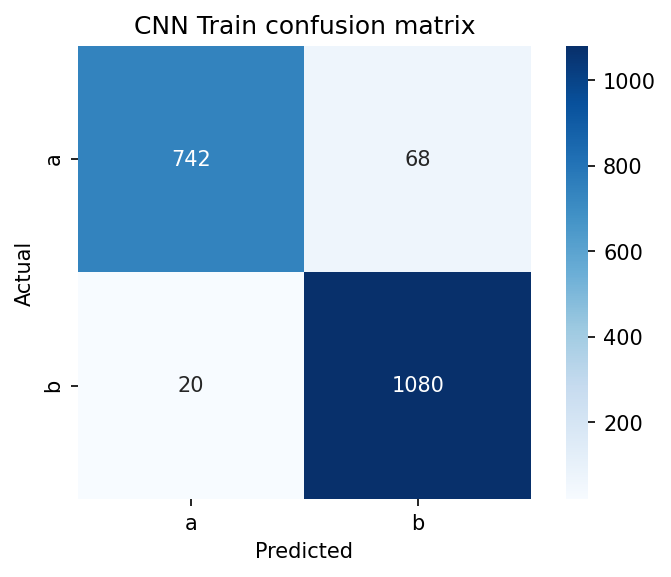

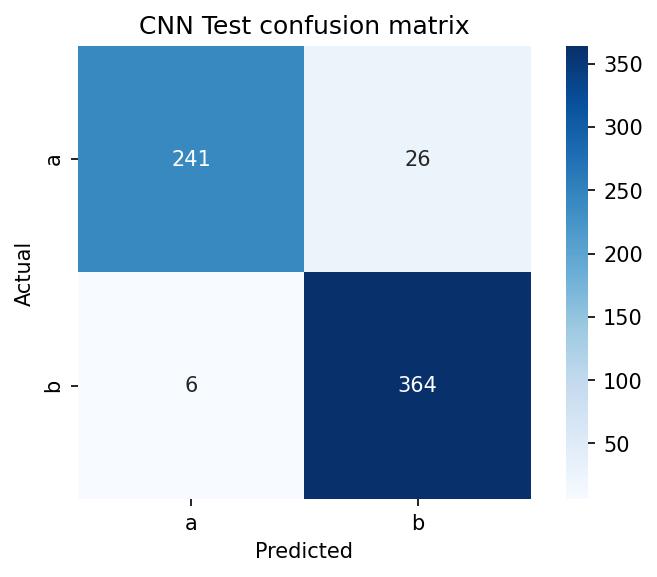

In [0]:
model_test_6 = run_CNN_5(X_train, X_test, y_train, y_test, epochs=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

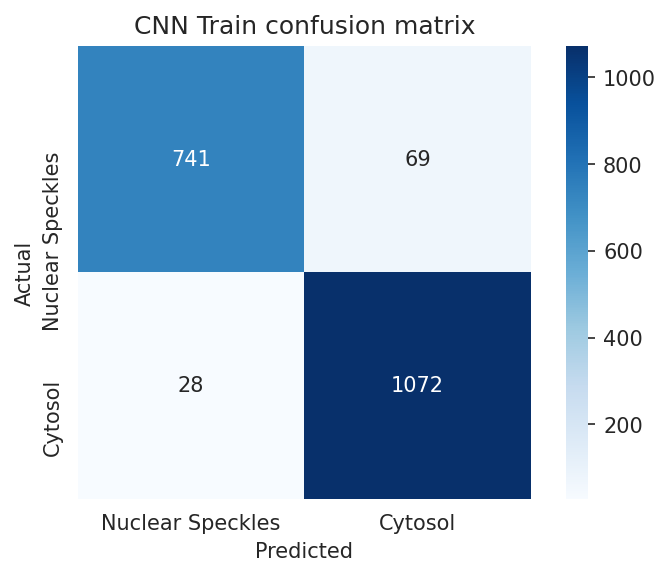

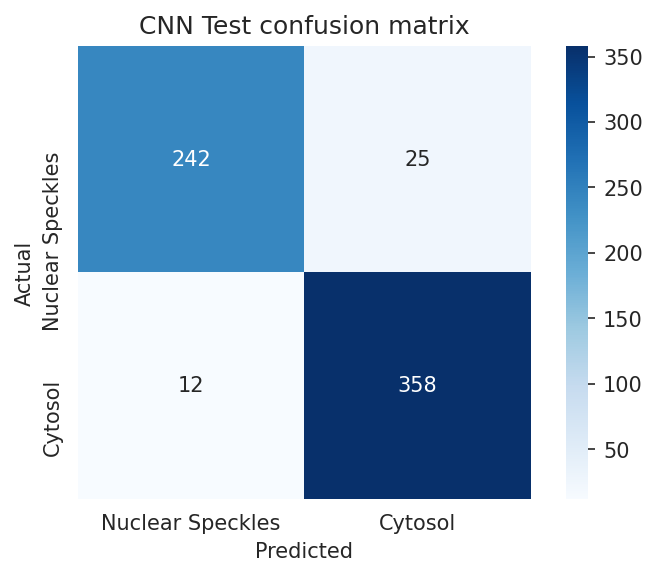

In [42]:
model_test_6b = run_CNN_5(X_train, X_test, y_train, y_test, epochs=100)

In [0]:
ar_4_predictions = model_test_6.predict_proba(ar_4)

In [0]:
ar_25_predictions = model_test_6.predict_proba(ar_25)

In [0]:
ar_4_predictions.shape

(1077, 1)

In [0]:
ar_25_predictions.shape

(1470, 1)

In [0]:
# np.savez_compressed('ar_4_predictions_14Jun.npz', ar_4_predictions)

In [0]:
# np.savez_compressed('ar_25_predictions_14Jun.npz', ar_25_predictions)

In [0]:
ar_4_pred_dict = np.load('ar_4_predictions_14Jun.npz')
ar_4_predictions = ar_4_pred_dict['arr_0']

In [0]:
ar_25_pred_dict = np.load('ar_25_predictions_14Jun.npz')
ar_25_predictions = ar_25_pred_dict['arr_0']


In [0]:
ar_4_wrong = ar_4_predictions[ar_4_predictions>0.5]

In [0]:
# np.savez_compressed('ar_4_wrong_14Jun.npz', ar_4_wrong)

In [0]:
df_4_wrong = df_4[ar_4_predictions>0.5]

In [0]:
# df_4_wrong.to_csv('df_4_wrong.csv')

In [0]:
len(df_4_wrong)

94

In [0]:
ar_4_wrong

array([0.7167678 , 0.9287652 , 0.7019415 , 0.55592114, 0.88612884,
       0.783458  , 0.7148167 , 0.7991425 , 0.6905985 , 0.89565164,
       0.7630606 , 0.93936926, 0.9852697 , 0.5730976 , 0.80742335,
       0.8428917 , 0.94200474, 0.520908  , 0.6102764 , 0.87201226,
       0.55053025, 0.7104766 , 0.5912384 , 0.66903925, 0.54242325,
       0.8442339 , 0.6206019 , 0.988283  , 0.60240954, 0.81119686,
       0.97966397, 0.50513375, 0.9970752 , 0.8220014 , 0.71416855,
       0.7373535 , 0.7757015 , 0.64891875, 0.98579365, 0.5600365 ,
       0.6630989 , 0.55537784, 0.861407  , 0.8063782 , 0.5820326 ,
       0.8969387 , 0.5523182 , 0.8346443 , 0.96973175, 0.76859957,
       0.6438889 , 0.5166337 , 0.7603246 , 0.5451966 , 0.73891515,
       0.6226669 , 0.67165476, 0.574735  , 0.8409649 , 0.66104454,
       0.6623854 , 0.6992525 , 0.6823019 , 0.56227237, 0.64295244,
       0.62329453, 0.71770376, 0.76975226, 0.9261788 , 0.7485168 ,
       0.8168459 , 0.883441  , 0.74101007, 0.7106181 , 0.68672

In [0]:
len(ar_4_wrong)

94

In [0]:
ar_25_wrong = ar_25_predictions[ar_25_predictions<0.5]

In [25]:
ar_25_wrong

array([3.8455918e-01, 4.9822792e-01, 4.7628990e-01, 4.5052966e-01,
       4.1721350e-01, 3.6759216e-01, 3.7848479e-01, 1.9849935e-01,
       3.7952873e-01, 4.2121306e-01, 3.8430339e-01, 4.6698073e-01,
       3.8730460e-01, 3.0787596e-01, 4.9726984e-01, 4.9868900e-01,
       4.3416819e-01, 4.7540012e-01, 3.8669421e-04, 2.8350821e-01,
       7.4226901e-02, 2.0965613e-01, 4.8593679e-01, 3.6539626e-01,
       3.3766490e-01, 3.9168704e-01], dtype=float32)

In [0]:
# np.savez_compressed('ar_25_wrong_14Jun.npz', ar_25_wrong)

In [0]:
df_25_wrong = df_25[ar_25_predictions<0.5]

In [0]:
# df_25_wrong.to_csv('df_25_wrong.csv')

In [27]:
len(ar_25_wrong)

26

In [0]:
sns.set_style('white')
sns.set(rc={"figure.figsize": (8, 6)})
ax = sns.distplot(ar_25_wrong, kde=False)
ax.set_title("Miscatorized Nuclear Speckles")

Text(0.5, 1.0, 'Miscatagorized Cytosol')

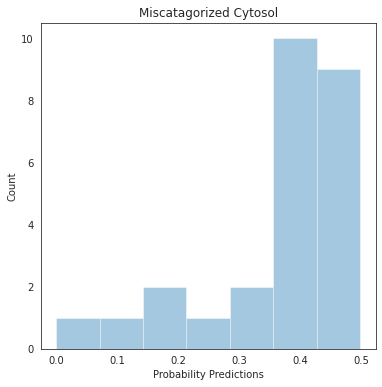

In [43]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(ar_25_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Cytosol")

Text(0.5, 1.0, 'Miscatagorized Nuclear Speckles')

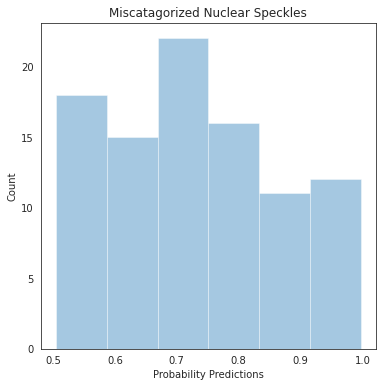

In [44]:
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(ar_4_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Nuclear Speckles")

In [0]:
ar_7_dict = np.load('arrays/ar_7.npz')

In [0]:
ar_7 = ar_7_dict['arr_0']

In [0]:
ar_7.shape

(1163, 224, 224, 3)

In [0]:
ar_21_dict = np.load('arrays/ar_21.npz')
ar_21 = ar_21_dict['arr_0']
ar_21.shape

(1058, 224, 224, 3)

In [0]:
X_train_2, X_test_2, y_train_2, y_test_2 = get_X_y_train_test_2(ar_7, ar_21)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

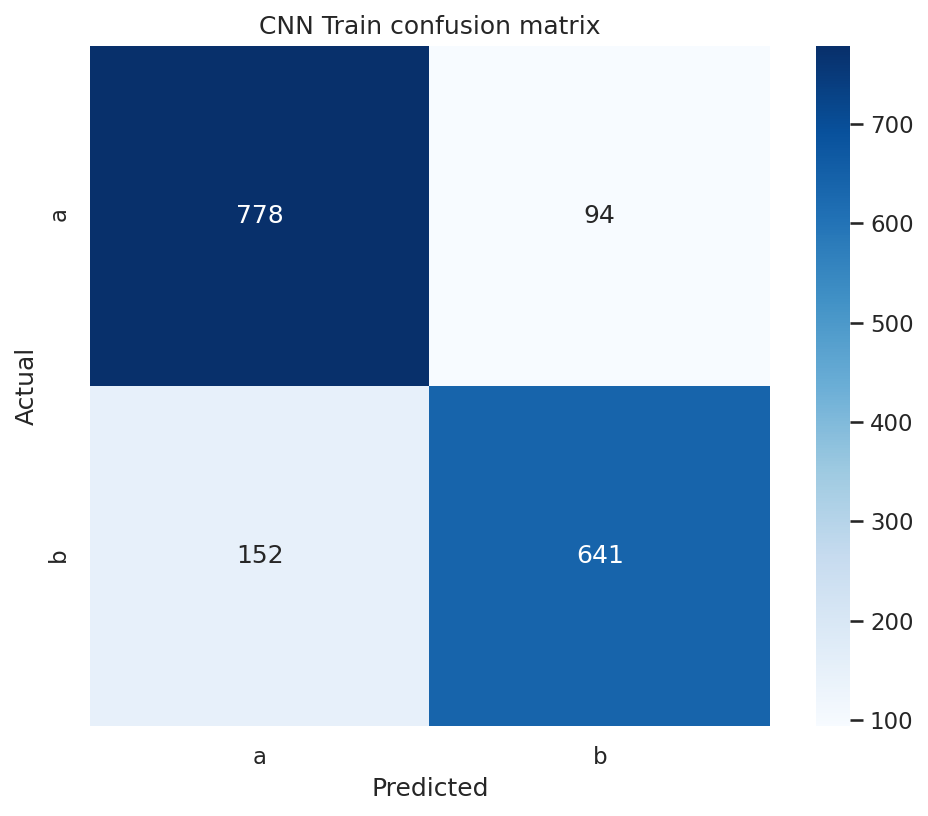

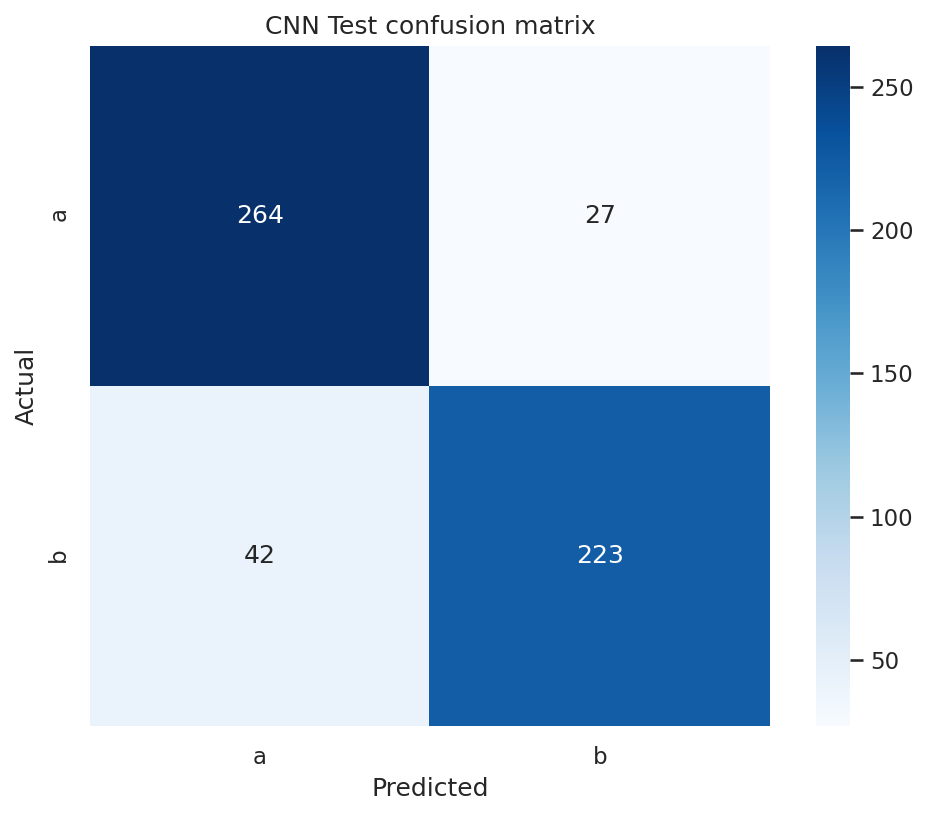

In [0]:
model_test_7 = run_CNN_5(X_train_2, X_test_2, y_train_2, y_test_2, epochs=100)

In [0]:
ar_7_predictions = model_test_7.predict_proba(ar_7)

In [0]:
ar_7_wrong = ar_7_predictions[ar_7_predictions>0.5]

In [0]:
np.savez_compressed('ar_7_predictions_14Jun.npz', ar_7_predictions)

In [0]:
ar_21_predictions = model_test_7.predict_proba(ar_21)
np.savez_compressed('ar_21_predictions_14Jun.npz', ar_21_predictions)

In [0]:
ar_21_wrong = ar_21_predictions[ar_21_predictions<0.5]

Text(0.5, 1.0, 'Miscatagorized Golgi Apparatus')

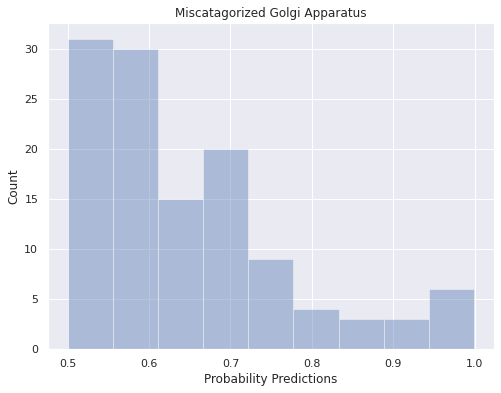

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(ar_7_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Golgi Apparatus")

Text(0.5, 1.0, 'Miscatagorized Plasma Membrane')

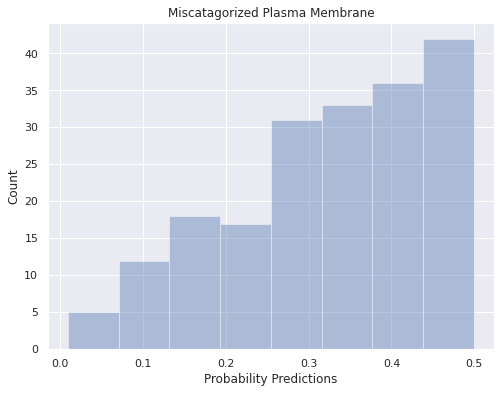

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(ar_21_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Plasma Membrane")

In [0]:
X_train_3, X_test_3, y_train_3, y_test_3 = get_X_y_train_test_2(ar_4, ar_7)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

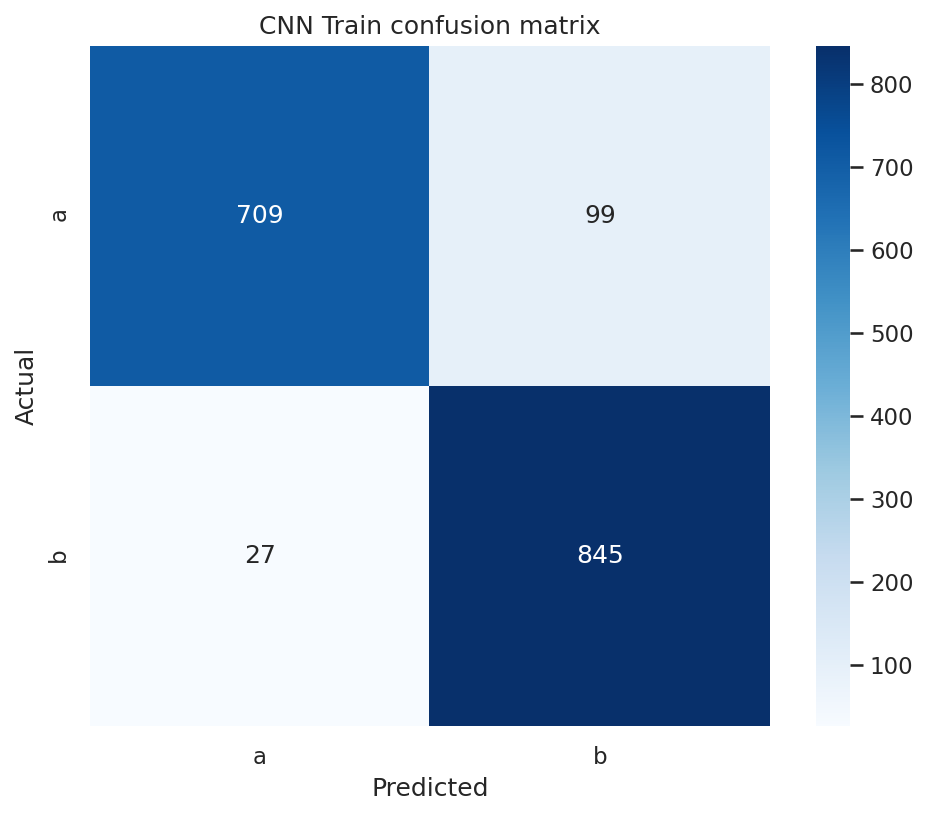

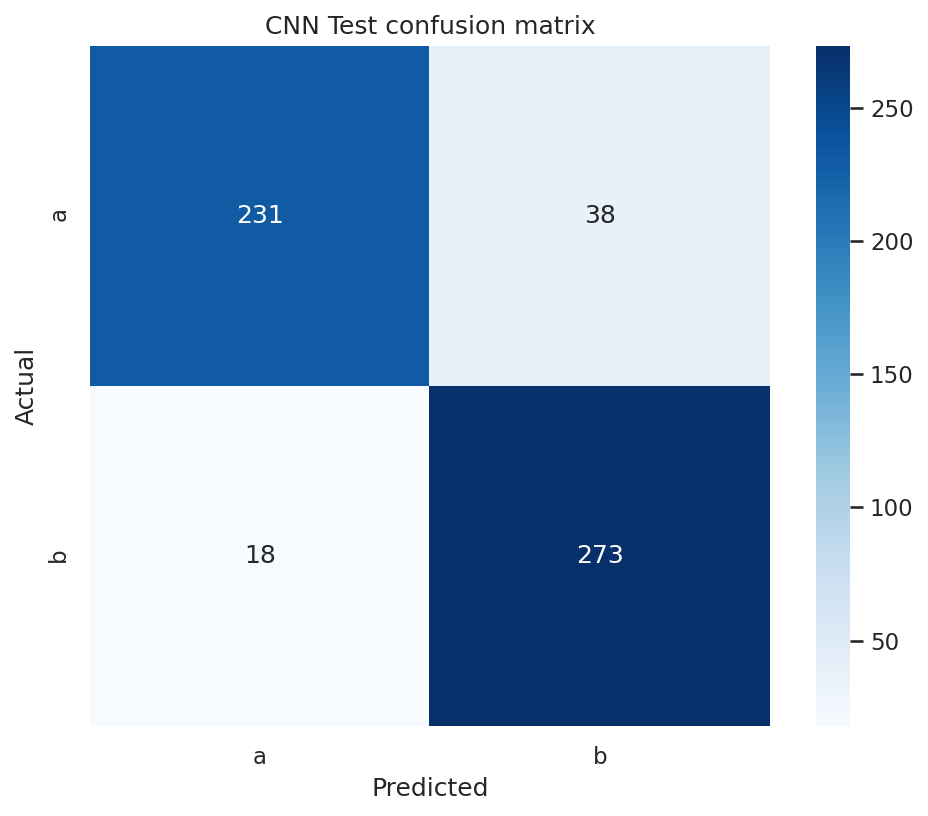

In [0]:
model_test_8 = run_CNN_5(X_train_3, X_test_3, y_train_3, y_test_3, epochs=100)

In [0]:
ar_4_w_7_predictions = model_test_8.predict_proba(ar_4)
np.savez_compressed('ar_4_w_7_predictions_14Jun.npz', ar_4_w_7_predictions)
ar_4_7_wrong = ar_4_w_7_predictions[ar_4_w_7_predictions>0.5]


In [0]:
ar_7_w_4_predictions = model_test_8.predict_proba(ar_7)
np.savez_compressed('ar_7_w_4_predictions_14Jun.npz', ar_7_w_4_predictions)
ar_7_4_wrong = ar_7_w_4_predictions[ar_7_w_4_predictions<0.5]


Text(0.5, 1.0, 'Miscatagorized Nuclear Speckles')

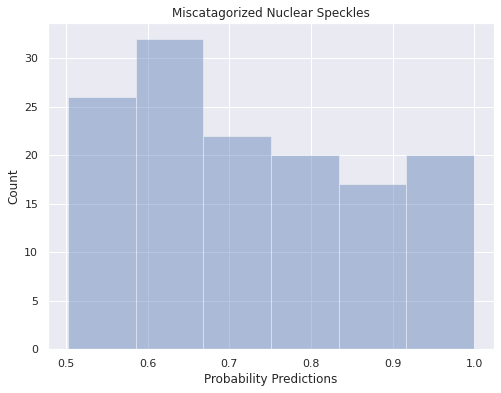

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(ar_4_7_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Nuclear Speckles")

Text(0.5, 1.0, 'Miscatagorized Golgi Apparatus')

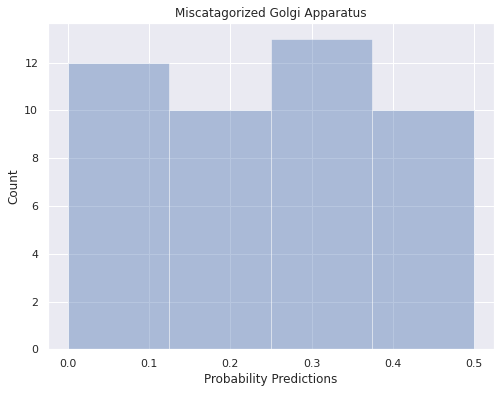

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(ar_7_4_wrong, kde=False, axlabel= "Probability Predictions", ax= ax)
ax.set_ylabel('Count')
ax.set_title("Miscatagorized Golgi Apparatus")